In [11]:
try:
    from dse.cluster import Cluster
except ImportError:
    from cassandra.cluster import Cluster

cluster = Cluster(['dse_seed_backend'])  # provide contact points and port
session = cluster.connect('davinci')

import pandas as pd

UnresolvableContactPoints: {}

In [5]:
#!pip install jupyterthemes
!jt -t grade3

/bin/sh: 1: jt: not found


In [6]:
from dateutil.parser import parse as parse_date

In [7]:
companies = session.execute("select ccvm, company_name, cnpj from bovespa_company;")
companies_df = pd.DataFrame(sorted(list(companies), key=lambda x: x.company_name))

companies_df.head(10)

,ccvm,company_name,cnpj
0,516384,PACATUBA HORTIGRANJEIRA S/A,06.625.313/0001-11
1,24163,PACIFIC RDSL PARTICIPAÇÕES S.A.,21.728.500/0001-14
2,80144,PACIFIC RUBIALES ENERGY CORP,-
3,13749,PAES MENDONCA SA,15.132.731/0001-68
4,509280,PAGRISA - PARÁ PASTORIL E AGRÍCOLA S/A,05.459.177/0001-74
5,505013,PAIAGUAS HOTEIS SA,01.982.156/0001-88
6,504025,PAIBASA PROJS AGRI IRRIG BA SA,12.908.232/0001-21
7,501972,PAINEIS INDUSTRIAIS DO NE SA,07.760.663/0001-53
8,501964,PAJUCARA AGROPEC SA,11.500.485/0001-07
9,501468,PAJUÇARA CONFECÇÕES S/A,06.642.342/0001-91


In [6]:
import json

        files_per_company = session.execute("select * from bovespa_company_file WHERE solr_query='{\"q\":\"*:*\", \"facet\": {\"field\": \"ccvm_exact\", \"limit\": 10000}}';").one()
files_per_company = json.loads(files_per_company.facet_fields)["ccvm_exact"]
files_per_company = pd.DataFrame([{"type": "Companies", "ccvm": ccvm, "num_files": round(num_files / 4, 0)} for ccvm, num_files in files_per_company.items()])
display("Total number of companies: {}".format(len(files_per_company)))

files_per_company.head(10)

'Total number of companies: 401'

,type,ccvm,num_files
0,Companies,11070,16.0
1,Companies,1155,16.0
2,Companies,15539,16.0
3,Companies,20346,16.0
4,Companies,22020,16.0
5,Companies,20567,15.0
6,Companies,1120,15.0
7,Companies,21342,14.0
8,Companies,21555,14.0
9,Companies,19658,14.0


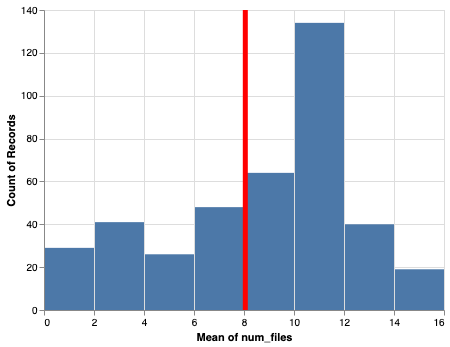

In [7]:
import altair as alt

bar = alt.Chart(files_per_company).mark_bar().encode(
    alt.X('num_files:Q', bin=True, axis=None),
    alt.Y('count()')
)

rule = alt.Chart(files_per_company).mark_rule(color='red').encode(
    x='mean(num_files):Q',
    size=alt.value(5)
)

bar + rule

In [8]:
def boxplot_altair(data, x, y, xtype='N', ytype='Q',
                   size=40, width=400):
    """
    Python function to make boxplots in Altair
    """
    # Define variables and their types using f-strings in Python
    lower_box=f'q1({y}):{ytype}'
    lower_whisker=f'min({y}):{ytype}'
    upper_box=f'q3({y}):{ytype}'
    upper_whisker=f'max({y}):{ytype}'
    median_whisker=f'median({y}):{ytype}'
    x_data=f'{x}:{xtype}'
 
    # lower plot
    lower_plot = alt.Chart(data).mark_rule().encode(
        y=alt.Y(lower_whisker, axis=alt.Axis(title=y)),
        y2=lower_box,
        x=x_data
    ).properties(
        width=width)
 
    # middle plot
    middle_plot = alt.Chart(data).mark_bar(size=size).encode(
        y=lower_box,
        y2=upper_box,
        x=x_data
    ).properties(
        width=width)
 
    # upper plot
    upper_plot = alt.Chart(data).mark_rule().encode(
        y=upper_whisker,
        y2=upper_box,
        x=x_data
    ).properties(
        width=width)
     
    # median marker line
    middle_tick = alt.Chart(data).mark_tick(
        color='white',
        size=size
    ).encode(
        y=median_whisker,
        x=x_data,
    )
     
    # combine all the elements of boxplot to a single chart object
    chart = lower_plot + middle_plot + upper_plot + middle_tick
     
    # return chart object
    return chart

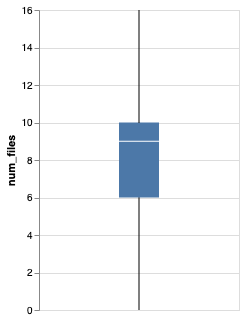

In [9]:
boxplot_altair(files_per_company, '', 'num_files', width=200)

In [9]:
def show_accounts(company_ccvm, balance_type, financial_info_type, period):
    global accounts
    
    print(company_ccvm)
    params = [company_ccvm, balance_type, financial_info_type, "{:%Y-%m-%d}".format(period)]
    rows = session.execute(
        "SELECT number, name, financial_info_type, balance_type, amount, comments FROM bovespa_account WHERE ccvm = %s AND balance_type = %s AND financial_info_type = %s AND period = %s;",
        parameters=params)
    rows = list(rows)
    if len(rows) > 0:
        pd.set_option('display.max_rows', 200)
        accounts = pd.DataFrame(list(rows))
        display(accounts[["number", "name", "amount", "comments"]])
    else:
        accounts = None
        display("No information available")

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

In [11]:
companies_df_subset = subset = companies_df[['company_name', 'ccvm']]
companies_options = [tuple(x) for x in companies_df_subset.values]

style = {'description_width': 'initial'}

company_ccvm_sel = widgets.Dropdown(
    options=companies_options,
    description='Company CCVM:',
    disabled=False,
    style=style
)

balance_type_options = [
    ("Capital (only Accumulated)", "IF"),
    ("Balance Sheet - Assets", "ASSETS"),
    ("Balance Sheet - Liabilities", "LIABILITIES"),
    ("Income Statement (P&L)", "DRE"), 
    ("Comprehensive Income", "DRA"),     
    ("Cash Flow Statement (Direct Method)", "DFC_MD"),     
    ("Cash Flow Statement (Indirect Method)", "DFC_MI"),     
    ("Equity and Cash", "DMPL"),
    ("Statement of Added Value", "DVA")    
]

balance_type_sel = widgets.Dropdown(
    options=balance_type_options,
    value='ASSETS',
    description='Balance Type:',
    disabled=False,
    style=style
)

financial_info_type_sel = widgets.Dropdown(
    options=[('Current', "INSTANT"), ('Accumulated', 'DURATION')],
    value='INSTANT',
    description='Financial Information Type:',
    disabled=False,
    style=style
)

period_sel = widgets.DatePicker(
    description='Fiscal period',
    value=parse_date("2013-06-30"),
    disabled=False,
    style=style
)

# interact(show_accounts, company_ccvm=company_ccvm_sel, balance_type=balance_type_sel, financial_info_type=financial_info_type_sel, period=period_sel)

out = widgets.interactive_output(show_accounts, {
    'company_ccvm': company_ccvm_sel, 
    'balance_type': balance_type_sel, 
    'financial_info_type': financial_info_type_sel,
    'period': period_sel})

widgets.VBox([widgets.HBox([company_ccvm_sel, period_sel]), 
              widgets.HBox([balance_type_sel, financial_info_type_sel]),
              out])

# Indicators

# Indicators over time (time series)